### Preliminaries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%bash
wget https://raw.githubusercontent.com/Qsinap/Breast-cancer-segmentation/main/Codes/MultiResUNet.py
wget https://raw.githubusercontent.com/Qsinap/Breast-cancer-segmentation/main/Codes/functions_seg.py
pip install keras==2.3.1
pip install tensorflow==2.2.0
pip install keras_applications==1.0.8
pip install image-classifiers==1.0.0
pip install efficientnet==1.0.0
pip install keras-unet
pip install tf-semantic-segmentation
pip install segmentation-models

In [ ]:
%env SM_FRAMEWORK=tf.keras

In [23]:
import functions_seg as fs
import pandas as pd
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os

### Losses and networks

In [7]:
losses={'binary_crossentropy': 'binary_crossentropy', 'dice_coef_loss': fs.dice_coef_loss, 'weighted_cross_entropyloss': fs.weighted_cross_entropyloss, 'tversky_loss': fs.tversky_loss, 'log_cosh_dice_loss': fs.log_cosh_dice_loss}
n_losses=['binary_crossentropy', 'dice_coef_loss', 'weighted_cross_entropyloss', 'tversky_loss', 'log_cosh_dice_loss']

In [8]:
backbones=['None', 'senet154', 'seresnet152', 'seresnext101', 'inceptionresnetv2', 'mobilenetv2', 'densenet201', 'resnet152', 'resnext101', 'efficientnetb7', 'vgg19']

### [Datos](https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM)


In [12]:
path='/content/drive/MyDrive/INDIGO_MLR/CancerDeMama/'

In [ ]:
df = pd.DataFrame(columns=('tumor_type','run_n', 'network', 'optimizer', 'loss', 'epochs', 'total_parameters', 'time','augm', 'jaccard_distances', 'acc','sensitivity','specificity','FPR','dice_coef', 'result_mat'))
df.head()

In [16]:
datos=sio.loadmat(path+'/data.mat')
images=datos['images'].astype('float32')
masks=(datos['masks']!=0).astype('float32')
n_ima,row,cols=np.shape(images)
images=images.reshape((*images.shape,1))
masks=masks.reshape((*masks.shape,1))
del datos

In [17]:
imagesRGB=np.zeros((n_ima, row, cols, 3))
imagesRGB[...,0]=imagesRGB[...,1]=imagesRGB[...,2]=images[...,0]
images=imagesRGB
del imagesRGB

In [ ]:
sp,sp2 = int(n_ima*0.8), int(n_ima*0.7)
x_test, x_train, x_val=images[sp:], images[:sp2], images[sp2:sp]
y_test, y_train, y_val=masks[sp:], masks[:sp2], masks[sp2:sp]
print(np.shape(x_test), np.shape(x_train), np.shape(x_val))
del images, masks

### Data augmentation

In [34]:
x_train=np.concatenate((x_train, np.flip(x_train, 2)), axis=0)
x_train=np.concatenate((x_train, np.rot90(x_train,1,axes=(1,2)),np.rot90(x_train,2,axes=(1,2)),np.rot90(x_train,3,axes=(1,2))), axis=0)
y_train=np.concatenate((y_train, np.flip(y_train, 2)), axis=0)
y_train=np.concatenate((y_train, np.rot90(y_train,1,axes=(1,2)),np.rot90(y_train,2,axes=(1,2)),np.rot90(y_train,3,axes=(1,2))), axis=0)

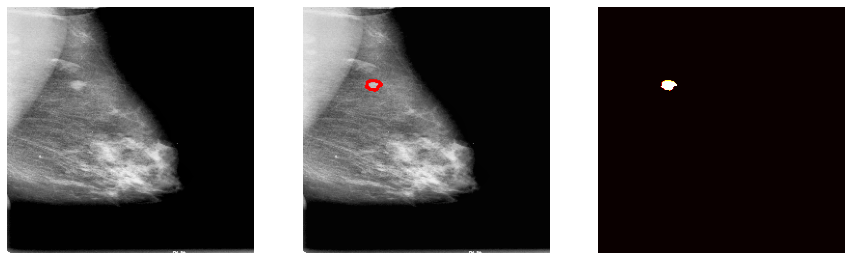

In [20]:
ind=np.random.choice(n_ima)
fs.plot_mamo(x_train[ind][...,0], y_train[ind][...,0])

### Training

In [21]:
paths=path+'weights/'

In [24]:
if os.path.exists(paths):
  print('done')
else:
  os.system('mkdir '+paths)

done


In [31]:
import time
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
from IPython.display import clear_output

red='Base_unet'

tumor_t=''
epochs=150
optimizer='Adam'
augmentation='8'

for back_b in backbones:
  network=red+'_'+back_b

  name='_'.join(['breast_cancer_'+str(tumor_t),network,optimizer])

  if not os.path.exists(path+name+'.csv'):
    df.to_csv(path+name+'.csv')

  for i in range(5):
    for j in n_losses:
      error=False
      tic = time.time()
      name_m='_'.join([name,j,'run',str(i)])  
      print(name_m)

      try:
        del model
      except:
        print('done')

      model=fs.read_model(red,back_b)
      model.compile(optimizer=optimizer, loss=losses[j], metrics=['acc', fs.jaccard_distance, fs.dice_coef])
      ES = EarlyStopping(patience=10, min_delta=0.00001, restore_best_weights=True)
      MCP = ModelCheckpoint(filepath=path+name_m+'_w.hdf5', save_best_only=True, save_weights_only=True)
      toc=time.time()-tic

      try:
        results = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=4, epochs=epochs)
        model.save_weights(paths+name_m+"w.h5")
      except:
        print('Training error')
        error=True
      
      if not error:
        sio.savemat(paths+name_m+'_r.mat', results.history)

        #validation
        fs.validation_modela_and_save(path+name+'.csv',i,j,name_m+'_r.mat')
        clear_output(wait=True)